# Web Scraping with BeautifulSoup

Let's look at how to install beautiful soup and then this will be our mission:

Which presidential candidate is mentioned the most in the politics section of the NY Times? Maybe even a word cloud will be made...

First install beautiful soup:

`pip install bs4` 

or

`conda install bs4` (probably)

In [97]:
from bs4 import BeautifulSoup

import re ## For parsing

import requests ## For getting the HTML

from wordcloud import WordCloud  ## For fun

import backoff

import matplotlib.pyplot as plt



### Intro to BeautifulSoup

BeautifulSoup takes the html from webpage and turns into an object that you can work with. All the tags and classes that a webpage have become attributes in a `Soup` object.

In [154]:
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""

In [139]:
soup = BeautifulSoup(html_doc)
soup

<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>
<p class="story">Once upon a time there were three little sisters; and their names were
<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>,
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a> and
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>
<p class="story">...</p>
</body></html>

In [140]:
soup.html

<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>
<p class="story">Once upon a time there were three little sisters; and their names were
<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>,
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a> and
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>
<p class="story">...</p>
</body></html>

In [141]:
soup.head

<head><title>The Dormouse's story</title></head>

In [142]:
soup.title

<title>The Dormouse's story</title>

In [143]:
soup.p

<p class="title"><b>The Dormouse's story</b></p>

In [146]:
soup.a

<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>

In [147]:
soup.find_all('a')

[<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>,
 <a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>,
 <a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>]

In [150]:
for tag in soup.find_all(True):
    print(tag.name)

html
head
title
body
p
b
p
a
a
a
p


## Now real website!

Let's look at the New york times politics section:

https://www.nytimes.com/news-event/2020-election

Seems like a nice look to work from. Let's go to the browser and check what we can see?

In [23]:
## Request the url

url = "https://www.nytimes.com/news-event/2020-election"

r= requests.get(url)
r

<Response [200]>

In [155]:
soup = BeautifulSoup(r.text, 'lxml')

In [132]:
soup

<!DOCTYPE html>
<html lang="en" xmlns:og="http://opengraphprotocol.org/schema/">
<head>
<title data-rh="true">Election 2020 - The New York Times</title>
<meta content="en-US" data-rh="true" itemprop="inLanguage"/><meta content="collection" data-rh="true" id="applicationName" name="applicationName"/><meta content="2020-election" data-rh="true" name="nyt-collection:identifier"/><meta content="2020-election" data-rh="true" name="CN"/><meta content="news_eventcollection" data-rh="true" name="nyt-collection:type"/><meta content="column" data-rh="true" name="CT"/><meta content="Politics" data-rh="true" name="nyt-collection:display-name"/><meta content="Read the latest on the 2020 election, including coverage of Donald Trump, Joe Biden, Elizabeth Warren, Bernie Sanders, Pete Buttigieg and more." data-rh="true" name="nyt-collection:tagline"/><meta content="" data-rh="true" name="nyt-collection:promotional-image"/><meta content="collection" data-rh="true" name="PT"/><meta content="1000000064765

limit_output extension: Maximum message size of 10000 exceeded with 1408783 characters

In [178]:
url_list = []

needed_divs = soup.find_all('div', class_ ="css-1l4spti")
for div in needed_divs:
    url_list.append(div.a.get('href'))
    
url_list

['/2020/02/13/us/politics/elizabeth-warren-bloomberg.html',
 '/2020/02/13/us/politics/nevada-culinary-union-endorsement.html',
 '/2020/02/13/climate/trump-fuel-economy-rollback.html',
 '/2020/02/13/us/politics/trump-bloomberg.html',
 '/2020/02/13/us/politics/hope-hicks-white-house-return.html',
 '/2020/02/13/us/politics/on-politics-sanders-nevada.html',
 '/2020/02/13/us/russian-propaganda-radio.html',
 '/2020/02/13/us/politics/nevada-caucuses.html',
 '/2020/02/13/us/politics/voting-smartphone-app.html',
 '/2020/02/13/style/michael-bloomberg-memes-jerry-media.html',
 '/2020/02/12/us/politics/new-hampshire-primary-turnout.html',
 '/2020/02/12/us/politics/bernie-sanders-democrats.html',
 '/2020/02/12/us/politics/on-politics-michael-bloomberg.html',
 '/2020/02/12/us/politics/troy-price-resigns-iowa.html',
 '/2020/02/12/us/politics/democrats-new-hampshire-sanders.html',
 '/2020/02/12/upshot/bernie-sanders-2020-path.html',
 '/2020/02/12/us/politics/elizabeth-warren-new-hampshire.html',
 '/20

Now let's go to each website and do our searches for each candidate. But wait!

### A brief foray into decorators and the `backoff` module

Oftentimes, when you loop through many webpages, the loop might break because you're making too many requests at once. 

That's what `backoff` is for. If the website gives an error, `backoff` will catch the exception and make the request again with some pause. The more times the exception is thrown the longer `backoff` will pause before making another one. 

`backoff` works as a decorator function. What's that? It's basically a function takes a function as an argument, but returns some "wrapper" for that function that references a function in it... What does that mean?

In [65]:
def add():
    print('1+2=3') 

add()


1+2=3


But now you wanted to make sure that people knew that this was a function about addition when they called it. You can write something like this:

In [66]:
def i_want_everyone_to_understand(func):
    
    def that_this_is_addition():
        print("just in case you didn't know, this is addition")
        func()
    return that_this_is_addition

add = i_want_everyone_to_understand(add)

add()

just in case you didn't know, this is addition
1+2=3


Instead of writing out the whole function, we can do:


In [70]:
@i_want_everyone_to_understand
def add():
    print("1+2=3")
    
add()

just in case you didn't know, this is addition
1+2=3


So `backoff` does this samething, but it catches exceptions of your function. So let's make out requests getter a function so we can use `backoff` with it.

In [73]:
@backoff.on_exception(backoff.expo,
                      requests.exceptions.RequestException)
def requester(url):
    return requests.get(url)



Now let's make our loop that gets the content from the webpage:

In [179]:
base_url = "https://www.nytimes.com"

articles = []

for relative_link in url_list:
    site = requester(base_url + relative_link).text
    articles.append(site)
    print(f"Accessing {base_url + relative_link}")

Accessing https://www.nytimes.com/2020/02/13/us/politics/elizabeth-warren-bloomberg.html
Accessing https://www.nytimes.com/2020/02/13/us/politics/nevada-culinary-union-endorsement.html
Accessing https://www.nytimes.com/2020/02/13/climate/trump-fuel-economy-rollback.html
Accessing https://www.nytimes.com/2020/02/13/us/politics/trump-bloomberg.html
Accessing https://www.nytimes.com/2020/02/13/us/politics/hope-hicks-white-house-return.html
Accessing https://www.nytimes.com/2020/02/13/us/politics/on-politics-sanders-nevada.html
Accessing https://www.nytimes.com/2020/02/13/us/russian-propaganda-radio.html
Accessing https://www.nytimes.com/2020/02/13/us/politics/nevada-caucuses.html
Accessing https://www.nytimes.com/2020/02/13/us/politics/voting-smartphone-app.html
Accessing https://www.nytimes.com/2020/02/13/style/michael-bloomberg-memes-jerry-media.html
Accessing https://www.nytimes.com/2020/02/12/us/politics/new-hampshire-primary-turnout.html
Accessing https://www.nytimes.com/2020/02/12/u

Now let's sift through and see what we can find. 

In [180]:
name_list = []

for i, article in enumerate(articles):
    for name in ['Sanders', 'Trump', 'Warren', 'Buttigieg', 'Klobuchar', 'Yang']:
        name_list.extend(re.findall(name,article))
    print(f"Going through article {i}")

Going through article 0
Going through article 1
Going through article 2
Going through article 3
Going through article 4
Going through article 5
Going through article 6
Going through article 7
Going through article 8
Going through article 9
Going through article 10
Going through article 11
Going through article 12
Going through article 13
Going through article 14
Going through article 15
Going through article 16
Going through article 17
Going through article 18
Going through article 19


In [181]:
name_list

['Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Sanders',
 'Trump',
 'Trump',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Warren',
 'Buttigieg',
 'Buttigieg',
 'Buttigieg',
 'Buttigieg',
 'Buttigieg',
 'Buttigieg',
 'Buttigieg',
 'Buttigieg',
 'Butti

limit_output extension: Maximum message size of 10000 exceeded with 11759 characters

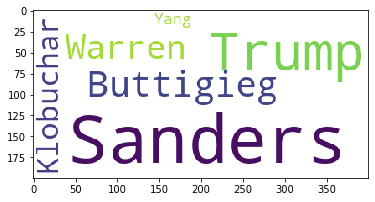

In [182]:
%matplotlib inline

name_text = ' '.join(name_list)

wordcloud = WordCloud(background_color="white", collocations=False).generate(name_text)

plt.imshow(wordcloud)